# **Hiperparaméter-hangolás**
Készítette: *Fogarassyné Vathy Ágnes*


## **1. Az adathalmaz előkészítése**

In [1]:
!pip install scikit-optimize

**Block 1.1** A hiperparaméterek hangolását a Titanic példán keresztül nézzük meg. Ehhez első lépésben előkészítjük az adathalmazt:

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# DataFrame létrehozása Excel fájlból
#titanic = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1_KorszDM_I/2_Osztalyozas/Titanic.xlsx')
titanic = pd.read_excel('Titanic.xlsx')

# Eldobjuk a NAME oszlopot
titanic.drop(labels='Name', axis=1, inplace=True)

# Dummy váltóvá konvertáljuk a SEX oszlopot (referencia kódolással, ezért csak 1 oszlop lesz belőle)
titanic['Sex'] = pd.get_dummies(titanic['Sex'], drop_first=True)

# DataFrame-et TULAJDONSÁGOK(features, X) és CÉL(target, y) tömbökre bontjuk
X = titanic.iloc[:, 1:].values
y = titanic.iloc[:, 0].values.reshape(-1,1)

# Tréning és teszt adatok létrehozása 2/3 és 1/3 vágással
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

## **2. Döntési fa hangolása**

**Block 2.1** Készítsünk egy döntési fát az alap hiperparaméterekkel:

In [4]:
clf_dtree = DecisionTreeClassifier(random_state=0)

clf_dtree = clf_dtree.fit(X_train,y_train)
y_pred_dtree = clf_dtree.predict(X_test)

print("Pontosság az alapbeállításokkal:",accuracy_score(y_test, y_pred_dtree))

Pontosság az alapbeállításokkal: 0.726962457337884


### **2.1 Hiperparaméter-hangolás GridSearchCV-vel**

**Block 2.2** Végezzük el a hiperparaméter-hangolást [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)-vel:

In [5]:
# GridSeachCV -vel paraméter finomhangolás Accuracy érték alapján

clf = DecisionTreeClassifier(random_state=0)
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(1,8),
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,10)
}

gridsearch = GridSearchCV(
    estimator = clf,
    param_grid = params,
    scoring = 'accuracy',
    cv = 5,
    n_jobs = -1,
    verbose = 0
)

grid_results = gridsearch.fit(X_train, y_train)

print(grid_results.best_params_)
print(grid_results.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2}
0.8264919527132888


    Összehasonlítható a GridSearch-el kapott pontosság a manuális paraméterekkel kapott pontossággal?
> NEM!!!!

> Miért?????

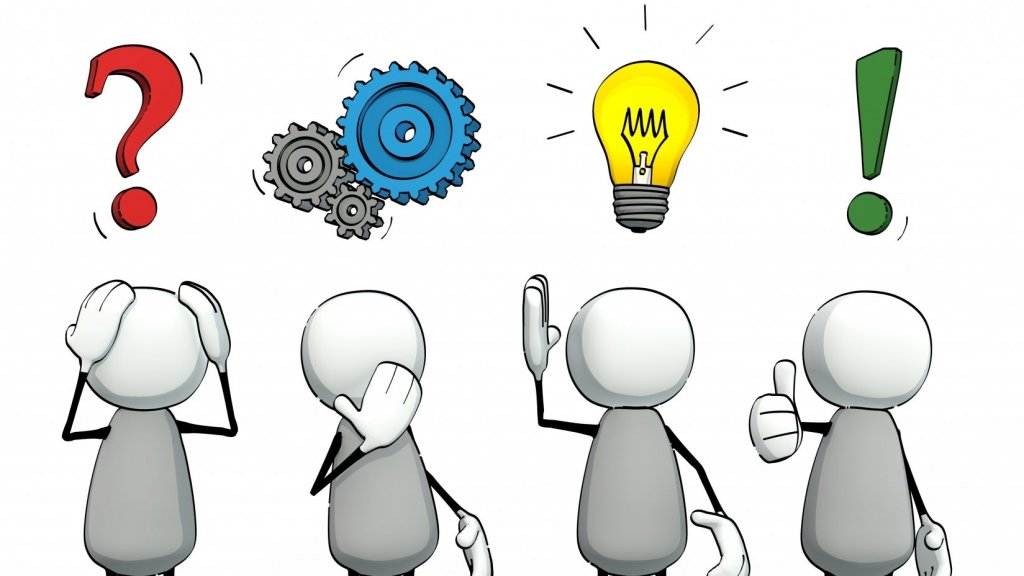

> Gondoljuk végig: A manuális beállításnál a modell a training adatokon jött létre, majd a teszt adatokon teszteltük. A GridSearchCV-nél a teljes adathalmazon történ keresztvalidálás és a megadott pontosság a keresztvalidálás eredménye...

**Block 2.3** Nézzük meg, hogy a legjobb modell eredménye mit ad a teszt halmazon:

In [6]:
y_test_pred_GS = grid_results.best_estimator_.predict(X_test)
print("Pontosság:",accuracy_score(y_test, y_test_pred_GS))

Pontosság: 0.8088737201365188


## **3. Random Forest hiperparaméter-hangolása**

**Block 3.1** Random Forest osztályozó létrehozása és a modell illesztése default paraméterekkel:

In [7]:
clf_randomforest = RandomForestClassifier(random_state=0)

clf_randomforest = clf_randomforest.fit(X_train, y_train.ravel())

print("A modell pontossága:", clf_randomforest.score(X_test,y_test))

A modell pontossága: 0.8156996587030717


**Block 3.2** Tapasztalat alapján beállított paraméterkombináció:

In [8]:
clf_randomforest2 = RandomForestClassifier(n_estimators=20, criterion="entropy",  max_depth=5, random_state=0)

clf_randomforest2 = clf_randomforest2.fit(X_train, y_train.ravel())

print("A modell pontossága:", clf_randomforest2.score(X_test,y_test))

#A modell pontosságát így is számolhattuk volna, de természetesen ugyanazt az értéket kapjuk:
#y_test_pred_rf3 = clf_randomforest2.predict(X_test)
#print("A modell pontossága:", accuracy_score(y_test, y_test_pred_rf2))

A modell pontossága: 0.8225255972696246


### **3.1 Hiperparaméter-hangolás RandomizedSearchCV-vel**

**Block 3.3** Hiperparaméter-hangolás [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)-vel:

In [9]:
# RandomizedSearchCV -vel paraméter finomhangolás accuracy érték alapján

clf = RandomForestClassifier(random_state=0)
params = {
    'n_estimators': [10, 20, 30, 40, 50, 100, 150, 200],
    'criterion' :['entropy', 'gini'],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'min_samples_split': range(2,10),
    'min_samples_leaf': range(1,10)
}

randomsearch = RandomizedSearchCV(
    estimator = clf,
    param_distributions = params,
    n_iter = 100,
    scoring = 'accuracy',
    cv = 5,
    verbose = 1
)

random_results = randomsearch.fit(X_train, y_train.ravel())
print(random_results.best_params_)
print(random_results.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 40, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'entropy'}
0.83160518444666


    *Megjegyzés:* A fenti kód RandomizedSearchCV keresés volt. Ugyanezen paraméterekkel lefuttatott GridSearchCV keresés kb. 55 percig fut, s a következő paraméterekkel tér vissza:

    {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 30}
    0.8283862697621421

**Block 3.4** A legjobb modell kiértékelése a teszt halmazon:

In [10]:
y_test_pred_RS = random_results.best_estimator_.predict(X_test)
print("Pontosság:",accuracy_score(y_test, y_test_pred_RS))

Pontosság: 0.8088737201365188


> Miért kaphatunk esetenként rosszabb az értéket???

> Tartsuk szem előtt, hogy a GridSearchCV és a RandomSearchCV is keresztvalidációval dolgozott, míg a manuálisan behangolt verzióban a teljes tréning halmazt használtuk a modell felépítésére.

### **3.2 Hiperparaméter-hangolás BayesSearchCV-vel**

**Block 3.5** Hiperparaméter-hangolás [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)-vel (kb. 5-10 perc):

In [11]:
# BayesSearchCV -vel paraméter finomhangolás accuracy érték alapján

clf = RandomForestClassifier(random_state=0)

params = {
    'n_estimators': [10, 20, 30, 40, 50, 100, 150, 200],
    'criterion': ['entropy', 'gini'],
    'max_depth': [2, 3, 4, 5, 6, 7]
}

bayessearch = BayesSearchCV(
    estimator=clf,
    search_spaces=params,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    verbose=1
)

bayes_results = bayessearch.fit(X_train, y_train.ravel())
print(bayes_results.best_params_)
print(bayes_results.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('entropy'), np.int64(7), np.int64(30)] before, using random point ['gini', 7, 20]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(7), np.int64(30)] before, using random point ['entropy', 2, 30]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(7), np.int64(200)] before, using random point ['entropy', 3, 200]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(7), np.int64(200)] before, using random point ['entropy', 3, 150]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('gini'), np.int64(7), np.int64(200)] before, using random point ['entropy', 6, 30]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
OrderedDict({'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200})
0.8399943028058681


**Block 3.6** A legjobb modell kiértékelése a teszt halmazon:

In [12]:
y_test_pred_BS = bayes_results.best_estimator_.predict(X_test)
print("Pontosság:",accuracy_score(y_test, y_test_pred_BS))

Pontosság: 0.8191126279863481


## **4. MLPClassifier paraméter és hiperparaméter hangolása**

**Block 4.1** Alapértelmezett paraméterekkel futassuk le az MLPClassifiert a Titanic adathalmazunkon!

In [13]:
# Példányosítsuk a modellünket, majd illeszük az edző halmazunkra
clf_nn = MLPClassifier(random_state=0)
clf_nn.fit(X_train, y_train.ravel())

/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,hidden_layer_sizes,"(100,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,0


In [14]:
y_pred_nn = clf_nn.predict(X_test)

print('F1 score: ', f1_score(y_true=y_test, y_pred=y_pred_nn))
print('Accuracy score: ', str(clf_nn.score(X_test,y_test)))
print('AUC:', roc_auc_score(y_true=y_test, y_score=y_pred_nn))

F1 score:  0.7665198237885462
Accuracy score:  0.8191126279863481
AUC: 0.8099557522123895


### **4.1 Paraméter és hiperparaméter-optimalizálás RandomizedSearchCV-vel**:

**Block 4.2** Paraméter és hiperparaméter-hangolás [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)-vel:

In [15]:
# RandomizedSeachCV -vel paraméter finomhangolás Accuracy érték alapján

clf = MLPClassifier(hidden_layer_sizes=(4), random_state=0)
params = {
    'activation': ['tanh', 'relu', 'logistic'],
    'hidden_layer_sizes' :[(2,), (3,), (4,), (5,)],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [50, 100, 500, 1000, 2000, 5000, 10000],
    'alpha': [0.0001, 0.001, 0.01],
    'random_state': [0]
}

randomsearch_nn = RandomizedSearchCV(
    estimator = clf,
    param_distributions = params,
    n_iter = 100,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 0
)

random_results_nn = randomsearch_nn.fit(X_train, y_train.ravel())
print(random_results_nn.best_params_)
print(random_results_nn.best_score_)

/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, s

{'solver': 'lbfgs', 'random_state': 0, 'max_iter': 5000, 'hidden_layer_sizes': (4,), 'alpha': 0.0001, 'activation': 'tanh'}
0.8097706879361916


**Block 4.3** A legjobb modell kiértékelése a teszt halmazon:

In [16]:
y_test_pred_RS_nn = random_results_nn.best_estimator_.predict(X_test)
print("Pontosság:",accuracy_score(y_test, y_test_pred_RS_nn))

Pontosság: 0.825938566552901


**Block 4.4** Paraméter és hiperparaméter hangolás AUC alapján:

In [17]:
# RandomizedSeachCV -vel finomhangolás AUC érték alapján

clf = MLPClassifier(hidden_layer_sizes=(4))
params = {
    'activation': ['tanh', 'relu', 'logistic'],
    'hidden_layer_sizes' :[(2,), (3,), (4,), (5,)],
    'solver': ['lbfgs', 'sgd'],
    'max_iter': [50, 100, 500, 1000, 2000, 5000, 10000],
    'alpha': [0.0001, 0.001, 0.01],
    'random_state': [0]
}

randomsearch_nn2 = RandomizedSearchCV(
    estimator = clf,
    param_distributions = params,
    n_iter = 100,
    scoring = 'roc_auc',
    n_jobs = -1,
    verbose = 0
)

random_results_nn2 = randomsearch_nn2.fit(X_train, y_train.ravel())
print(random_results_nn2.best_params_)
print(random_results_nn2.best_score_)


/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/tothi/pysrc/pemik/fgt/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, sel

{'solver': 'lbfgs', 'random_state': 0, 'max_iter': 2000, 'hidden_layer_sizes': (5,), 'alpha': 0.01, 'activation': 'relu'}
0.8592700681622659


**Block 4.5** A legjobb modell kiértékelése a teszt halmazon:

In [18]:
y_test_pred_RS_nn2 = random_results_nn2.best_estimator_.predict(X_test)
print('AUC:', roc_auc_score(y_true=y_test, y_score=y_test_pred_RS_nn2))
print("Pontosság:",accuracy_score(y_test, y_test_pred_RS_nn2))

AUC: 0.7789823008849557
Pontosság: 0.7952218430034129
